In [9]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D , Dense  , GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [10]:
tf.config.run_functions_eagerly(True)

In [11]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [12]:
# cap = cv2.VideoCapture(0)
# for imgnum in  range(number_images):
#     print('collecting images{}'.format(imgnum))
#     ret, frame =  cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname,frame)
#     cv2.imshow('frame',frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xff == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [13]:
#avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [14]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [15]:
images = tf.data.Dataset.list_files('data\\train\\images\\*.jpg',shuffle=False)

In [16]:
images.as_numpy_iterator().next()

b'data\\train\\images\\9b1af4d8-501f-11f0-aa3b-ce64918544f7.jpg'

In [17]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_images)

C:\Users\pdang\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [19]:
images.as_numpy_iterator( ).next()

array([[[201, 212, 218],
        [200, 211, 217],
        [201, 210, 217],
        ...,
        [231, 237, 233],
        [231, 237, 233],
        [235, 241, 237]],

       [[201, 212, 218],
        [201, 212, 216],
        [202, 211, 218],
        ...,
        [235, 240, 236],
        [234, 239, 235],
        [235, 240, 236]],

       [[200, 214, 217],
        [199, 213, 214],
        [202, 213, 217],
        ...,
        [237, 239, 238],
        [235, 237, 236],
        [233, 235, 234]],

       ...,

       [[152, 145, 135],
        [146, 139, 129],
        [145, 136, 127],
        ...,
        [153, 133, 122],
        [154, 134, 123],
        [157, 139, 127]],

       [[147, 138, 131],
        [143, 134, 127],
        [143, 134, 125],
        ...,
        [157, 137, 126],
        [159, 139, 128],
        [161, 141, 130]],

       [[145, 136, 129],
        [142, 133, 126],
        [144, 135, 126],
        ...,
        [167, 145, 134],
        [165, 145, 134],
        [161, 141, 130]]

In [20]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

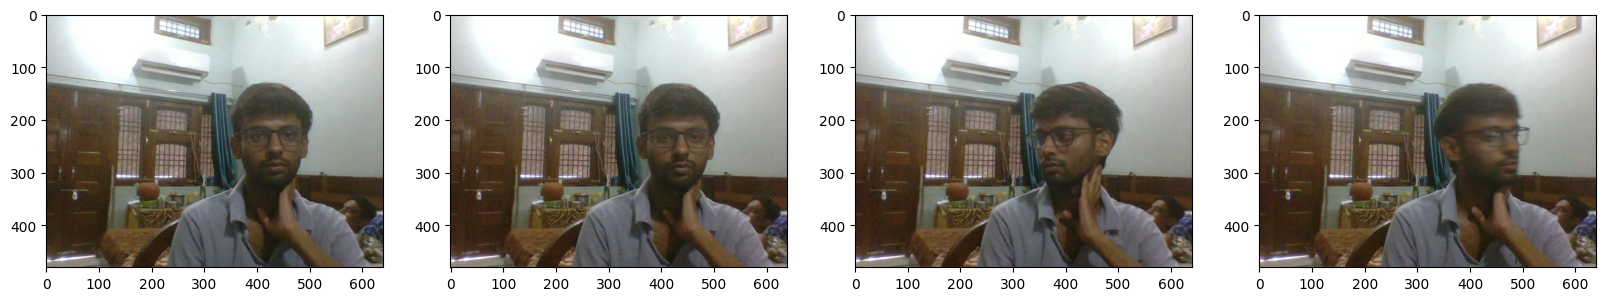

In [23]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [24]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split( '.' )[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)

In [25]:
import albumentations as alb

In [26]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),alb.RGBShift(p=0.2),alb.VerticalFlip(p=0.5)],
                         bbox_params= alb.BboxParams(format = 'albumentations',label_fields= ['class_labels']))

In [27]:
img = cv2.imread(os.path.join('data','train','images','9b1af4d8-501f-11f0-aa3b-ce64918544f7.jpg'))

In [28]:
with open(os.path.join('data','train','labels','9b1af4d8-501f-11f0-aa3b-ce64918544f7.json'), 'r') as f:
    label = json.load(f)

In [29]:
label['shapes'][0]['points']

[[342.98578199052133, 127.2037914691943],
 [523.0805687203791, 332.41706161137444]]

In [30]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [31]:
coords

[342.98578199052133, 127.2037914691943, 523.0805687203791, 332.41706161137444]

In [32]:
coords = list(np.divide(coords, [640,480,640,480]))

In [33]:
coords

[np.float64(0.5359152843601895),
 np.float64(0.26500789889415477),
 np.float64(0.8173133886255923),
 np.float64(0.6925355450236967)]

In [34]:
augmented = augmentor(image=img,bboxes=[coords],class_labels = ['face'])

In [35]:
augmented

{'image': array([[[251, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[248, 255, 255],
         [252, 255, 255],
         [254, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[246, 255, 255],
         [250, 255, 255],
         [251, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[147, 137, 137],
         [146, 137, 134],
         [147, 138, 135],
         ...,
         [ 72,  78,  96],
         [ 74,  78,  95],
         [ 78,  81,  95]],
 
        [[147, 137, 137],
         [147, 138, 135],
         [148, 139, 136],
         ...,
         [ 75,  79,  97],
         [ 75,  77,  94],
         [ 77,  80,  94]],
 
        [[146, 138, 139],
         [147, 139, 139],
         [148, 140, 140],
         ...,
         [ 79,  83,

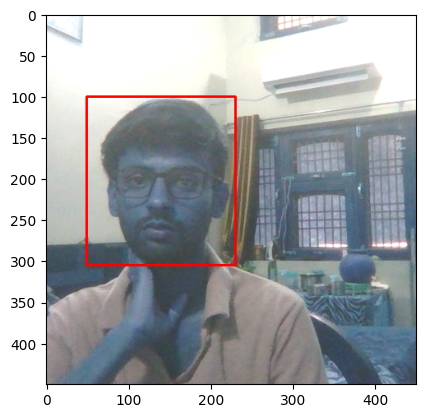

In [36]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])

In [37]:
# for partition in ['train','test','val']:
#     for image in os.listdir(os.path.join('data',partition,'images')):
#         img = cv2.imread(os.path.join('data',partition,'images',image))

#         coords = [0,0,0.00001,0.00001]
#         label_path = os.path.join('data', partition ,'labels',f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path):
#             with open(label_path,'r') as f:
#                 label = json.load(f)
            
#             coords[0] = label['shapes'][0]['points'][0][0]
#             coords[1] = label['shapes'][0]['points'][0][1]
#             coords[2] = label['shapes'][0]['points'][1][0]
#             coords[3] = label['shapes'][0]['points'][1][1]
#             coords = list(np.divide(coords, [640,480,640,480]))
        
#         try:
#             for x in range(60):
#                 augmented = augmentor(image = img , bboxes=[coords] , class_labels = ['face'])
#                 cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])


#                 annotation = {}
#                 annotation['image'] = image

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0,0,0,0]
#                         annotation['class'] = 0
                    
#                     else: 
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
                    
#                 else: 
#                     annotation['bbox'] = [0,0,0,0]
#                     annotation['class'] = 0
                
#                 with open(os.path.join('aug_data', partition, 'labels' , f'{image.split(".")[0]}.{x}.json'),'w') as f:
#                     json.dump(annotation,f)
        
#         except Exception as e:
#             print(e)


In [38]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x , (120,120)))
train_images = train_images.map(lambda x: x/255)


In [39]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x , (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x , (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

array([[[0.20833333, 0.19264705, 0.14705883],
        [0.303125  , 0.32322302, 0.30851716],
        [0.30765933, 0.34332108, 0.34901962],
        ...,
        [0.34381127, 0.3276348 , 0.39675245],
        [0.35851717, 0.3377451 , 0.41470587],
        [0.37947303, 0.3548407 , 0.43878677]],

       [[0.16924019, 0.13897058, 0.09258579],
        [0.19877452, 0.19626226, 0.17751226],
        [0.2940564 , 0.315625  , 0.31458333],
        ...,
        [0.33541667, 0.30214462, 0.27959558],
        [0.37555146, 0.35398284, 0.30729166],
        [0.43247548, 0.421875  , 0.37120098]],

       [[0.1913603 , 0.14528187, 0.09393382],
        [0.17928922, 0.15422794, 0.12334559],
        [0.22800244, 0.22408088, 0.2036152 ],
        ...,
        [0.30876225, 0.29319853, 0.24656862],
        [0.35582107, 0.33425245, 0.28713235],
        [0.30514705, 0.27389705, 0.21366422]],

       ...,

       [[0.9825368 , 0.99969363, 0.99577206],
        [0.9768995 , 1.        , 0.9925858 ],
        [0.96862745, 1

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding = 'utf-8') as f:
        label = json.load(f)
    
    return [label['class']],label['bbox']

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [44]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.2834, 0.311 , 0.7397], dtype=float16))

In [45]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [46]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8,tf.float16]))

In [47]:
len(train_images), len(train_labels), len(test_images), len(test_labels) , len(val_images) , len(val_labels)

(3780, 3780, 840, 840, 840, 840)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)


In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.5273 , 0.09485, 0.8594 , 0.4688 ],
        [0.1877 , 0.5747 , 0.516  , 0.9224 ],
        [0.484  , 0.51   , 0.7954 , 0.905  ],
        [0.     , 0.09534, 0.202  , 0.4492 ],
        [0.543  , 0.574  , 0.865  , 0.9326 ],
        [0.8413 , 0.1287 , 1.     , 0.587  ],
        [0.6445 , 0.509  , 0.9565 , 0.9404 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


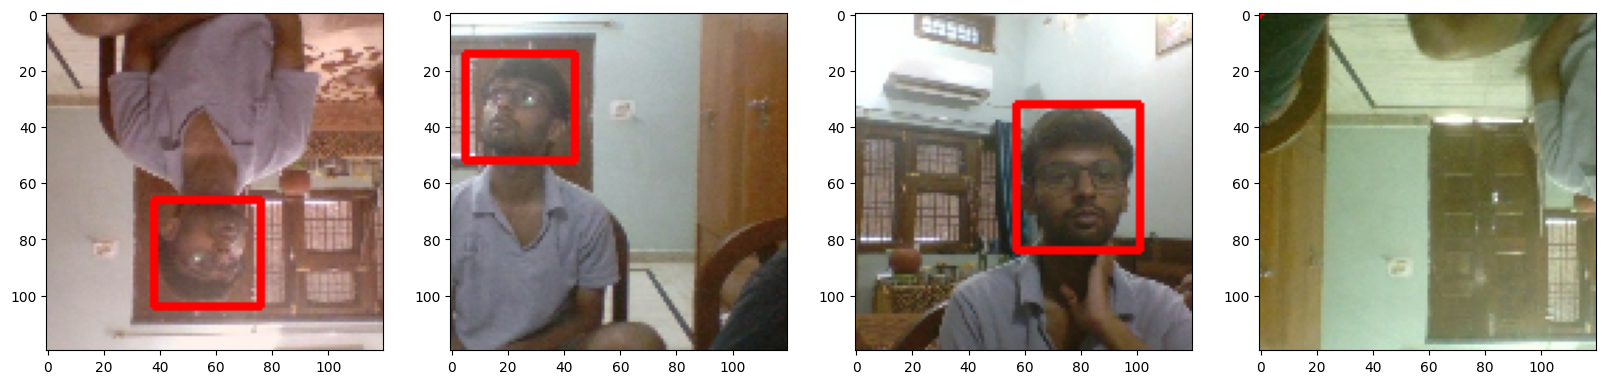

In [54]:
fig, ax = plt.subplots(ncols=4 , figsize=(20,20))
for idx in range(4):
    sample_image = np.array(res[0][idx]).copy() 
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    ax[idx].imshow(sample_image)

In [55]:
vgg = VGG16(include_top = False)

In [56]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)
    f1 = GlobalMaxPooling2D()(vgg)
    # classification Layer
    
    class1 = Dense(2048,activation = 'relu')(f1)
    class2 = Dense(1 , activation = 'sigmoid')(class1)
    #regression layer or bounding box model
    # f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f1)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)

    facetracker = Model(inputs = input_layer , outputs = [class2, regress2])
    return facetracker

In [58]:
train.as_numpy_iterator().next()[0]

array([[[[6.82352960e-01, 7.17647076e-01, 6.99142158e-01],
         [6.84497535e-01, 7.19975471e-01, 7.09191203e-01],
         [6.86642170e-01, 7.20955908e-01, 7.27328420e-01],
         ...,
         [7.34313726e-01, 7.65686274e-01, 7.77450979e-01],
         [7.32169092e-01, 7.53247559e-01, 7.64522076e-01],
         [7.26348042e-01, 7.45036781e-01, 7.55882382e-01]],

        [[6.91360295e-01, 7.28124976e-01, 7.19914198e-01],
         [6.96568608e-01, 7.35906839e-01, 7.33762264e-01],
         [6.84007347e-01, 7.24203408e-01, 7.27634788e-01],
         ...,
         [7.17585802e-01, 7.49448538e-01, 7.55821049e-01],
         [7.30024517e-01, 7.52879918e-01, 7.62254894e-01],
         [7.28370070e-01, 7.43566155e-01, 7.59068608e-01]],

        [[6.70710802e-01, 7.07475483e-01, 7.06495106e-01],
         [6.84865177e-01, 7.24080861e-01, 7.28002429e-01],
         [6.70526981e-01, 7.17585802e-01, 7.09742665e-01],
         ...,
         [7.00919092e-01, 7.36213207e-01, 7.24448502e-01],
         [

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
X, y =train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


In [64]:
classes, coords

(array([[0.46265674],
        [0.42036462],
        [0.4273068 ],
        [0.42740014],
        [0.37458465],
        [0.422845  ],
        [0.37288812],
        [0.4172402 ]], dtype=float32),
 array([[0.3461616 , 0.36950552, 0.6884811 , 0.41039732],
        [0.34557718, 0.39587072, 0.67930317, 0.37383136],
        [0.30110496, 0.38558722, 0.6069157 , 0.33709997],
        [0.31008488, 0.34468326, 0.60012186, 0.3013632 ],
        [0.2858473 , 0.3878437 , 0.67344517, 0.3388394 ],
        [0.32057995, 0.41624722, 0.5804213 , 0.37266207],
        [0.2139504 , 0.39206442, 0.6838892 , 0.36518735],
        [0.3524455 , 0.3763464 , 0.6187118 , 0.2536167 ]], dtype=float32))

In [65]:
len(train)

473

In [66]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch

In [67]:
lr_decay

0.0007047216349541929

In [68]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [69]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [71]:
localization_loss(y[1], coords).numpy()

np.float32(2.6757212)

In [72]:
classloss(y[0], classes).numpy()

np.float32(0.8435124)

In [73]:
print("y:", y)
print("y[0].shape:", tf.shape(y[0]))
print("y[1].shape:", tf.shape(y[1]))


y: (array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8), array([[0.      , 0.10236 , 0.015335, 0.4656  ],
       [0.0196  , 0.04996 , 0.3525  , 0.4092  ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.2546  , 0.421   , 0.6895  ],
       [0.4482  , 0.05872 , 0.7705  , 0.4167  ],
       [0.3037  , 0.502   , 0.615   , 0.934   ],
       [0.402   , 0.12354 , 0.6685  , 0.4773  ],
       [0.3853  , 0.2683  , 0.773   , 0.741   ]], dtype=float16))
y[0].shape: tf.Tensor([8 1], shape=(2,), dtype=int32)
y[1].shape: tf.Tensor([8 4], shape=(2,), dtype=int32)


In [74]:
class FaceTracker(Model):
    def __init__(self,facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
    
    def compile(self, opt , classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self,batch, **kwargs):
        X,y = batch

        with tf.GradientTape() as tape:
            classes , coords = self.model(X, training = True)

            batch_classloss = self.closs(y[0],classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5*batch_classloss

        grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss , "class_loss":batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self,batch, **kwargs):
        X,y = batch

        
        classes , coords = self.model(X, training = False)

        batch_classloss = self.closs(y[0],classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

        total_loss = batch_localizationloss + 0.5*batch_classloss

           
        return {"total_loss":total_loss , "class_loss":batch_classloss, "regress_loss": batch_localizationloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

        

In [75]:
model = FaceTracker(facetracker)

In [76]:
model.compile(opt, classloss, regressloss)

In [77]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train.take(100), epochs= 100, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - class_loss: 0.2844 - regress_loss: 0.6576 - total_loss: 0.7998 - val_class_loss: 0.1886 - val_regress_loss: 0.3981 - val_total_loss: 0.4924
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - class_loss: 0.2206 - regress_loss: 0.5066 - total_loss: 0.6169 - val_class_loss: 0.2445 - val_regress_loss: 0.2793 - val_total_loss: 0.4015
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - class_loss: 0.1337 - regress_loss: 0.2526 - total_loss: 0.3194 - val_class_loss: 0.0197 - val_regress_loss: 0.0768 - val_total_loss: 0.0867
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - class_loss: 0.1620 - regress_loss: 0.3399 - total_loss: 0.4209 - val_class_loss: 0.4104 - val_regress_loss: 0.4629 - val_total_loss: 0.6681
Epoch 5/100
 52/100 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - class_loss: 0.1256 - regress_loss: 0.2301 - total_loss: 0.2929

In [ ]:
hist.history

{'class_loss': [0.0030884789302945137,
  0.5205814242362976,
  0.006622892338782549,
  0.0001223574363393709,
  0.0003142191271763295,
  0.002078260760754347,
  0.002347887260839343,
  0.0015497596468776464,
  6.915965059306473e-05,
  0.0008629461517557502],
 'regress_loss': [0.037234801799058914,
  0.9324624538421631,
  0.029650993645191193,
  0.026111355051398277,
  0.00991877168416977,
  0.024785621091723442,
  0.003947264514863491,
  0.005531412549316883,
  0.0072540659457445145,
  0.01680181920528412],
 'total_loss': [0.03877904266119003,
  1.1927531957626343,
  0.03296244144439697,
  0.026172533631324768,
  0.010075881145894527,
  0.02582475170493126,
  0.005121208261698484,
  0.006306292489171028,
  0.007288645952939987,
  0.017233291640877724],
 'val_class_loss': [0.3167151212692261,
  0.8950219750404358,
  0.004006846342235804,
  0.0003800378763116896,
  0.2907279431819916,
  0.02150336094200611,
  0.6628284454345703,
  1.2394155263900757,
  0.834545373916626,
  0.003778474871

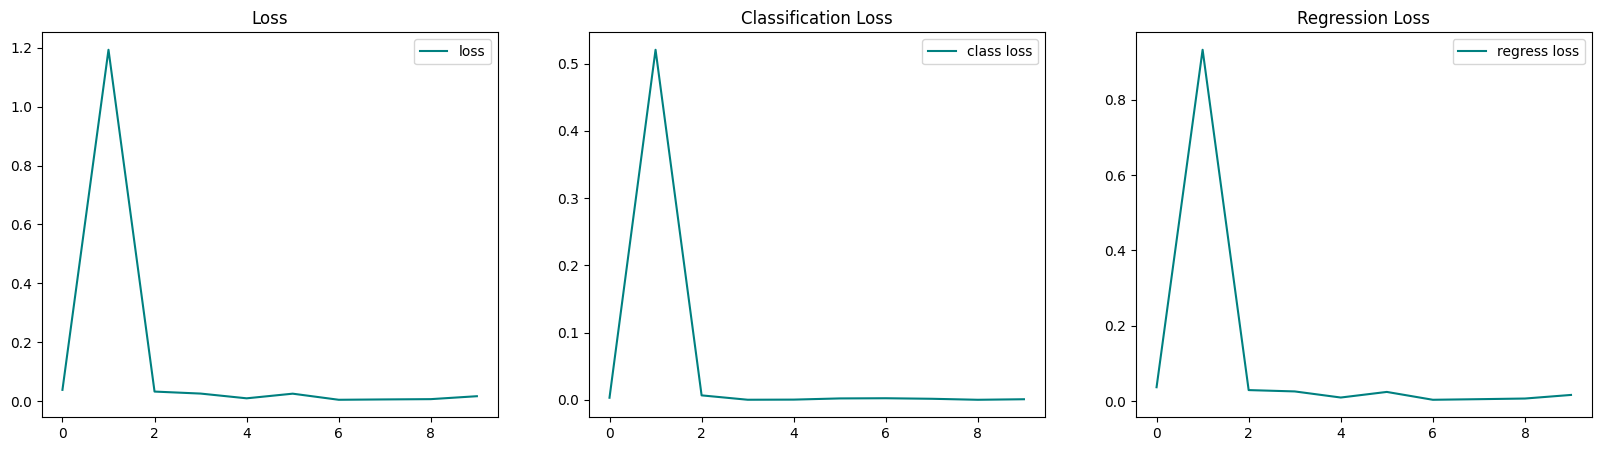

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label = 'loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label = 'class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label = 'regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

C:\Users\pdang\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


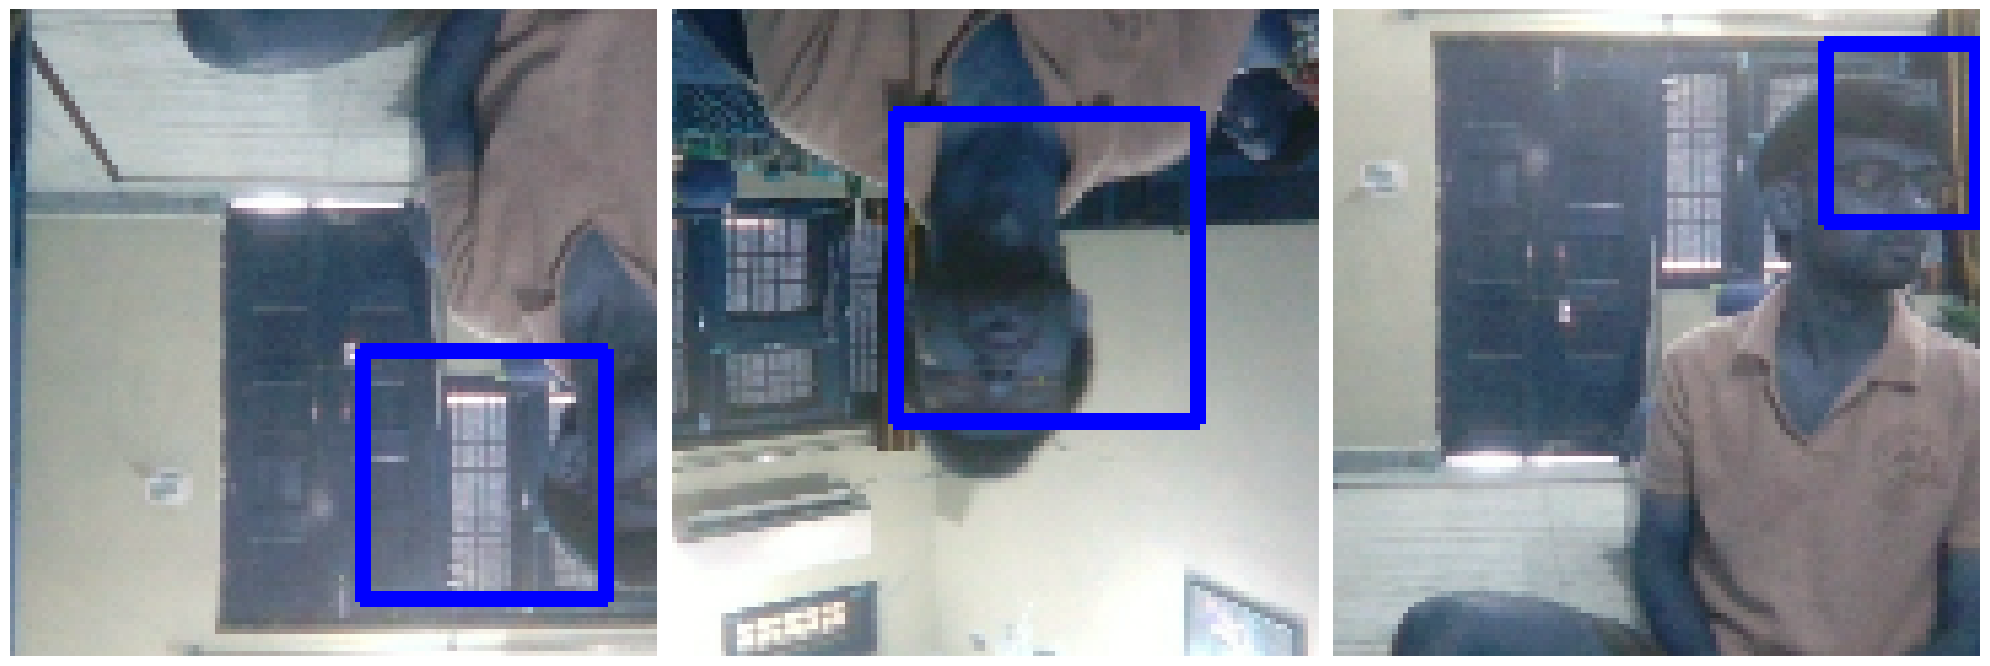

In [ ]:
X_batch, y_batch = next(test_data)

fig, ax = plt.subplots(ncols=3, figsize=(20, 20))

for idx in range(3):
    sample_image = X_batch[idx].copy()  # Make writeable copy
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

    # Convert BGR (OpenCV) to RGB (matplotlib) if needed
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    ax[idx].imshow(sample_image)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isopened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:],[450,450]).astype(int)),
                      (255,0,0),2
                 )
        
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int)[0,-30])),
                      tuple(np.add(np.multiply(sample_coords[2:],[450,450]).astype(int)[80,0])),
                      (255,0,0),-1
                 )
        
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),
                                                [0,-5])),
                                                cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2, cv2.LINE_AA)
        
    cv2.imshow('Facetrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()